In [329]:
# This file will be used to visualize transformer attention dumps
import pickle, pdb
import sys
sys.path.append('..')
import utils
from collections import defaultdict as ddict
import numpy as np
from helper import *

In [2]:
import torch_geometric

In [24]:
from torch_geometric.utils import add_remaining_self_loops

In [258]:
#data = load_pickle('./predictions/graph_test_607d1765-164c-4426-9595-7dbf01ba6150_20_05_2020_01:14:45_predictions.pkl')
data = load_pickle('../bot/predictions/basic_final_graph_seller_gat_64_08_2_001_BERT_28_06_2020_06:01:24_predictions.pkl')

In [259]:
data.keys()

dict_keys(['loss', 'metrics', 'all_preds', 'all_labels', 'all_attn_wts', 'all_extra_perm', 'all_input_graphs'])

In [260]:
num_batches = len(data['all_labels'])
print (num_batches)

74


In [261]:
def my_batch_to_list(batch_data, attn_wts, expand_self_loops = True):
    '''
    Takes a batch data, and attention weights and returns a list of torch_geometric.Data
    '''
    edge_index = batch_data.edge_index
    batch = batch_data.batch.cpu().numpy()
    x = batch_data.x.cpu().numpy().flatten()
    y = batch_data.y.cpu().numpy()
    num_graphs = len(batch)
    if expand_self_loops:
        edge_index = add_remaining_self_loops(edge_index)[0].cpu().numpy()
    assert edge_index.shape[1] == attn_wts.shape[0]
    
    data_list = []
    curr_data = 0
    num_batches = np.max(batch) + 1
    batch_idx = 0
    while curr_data < num_batches:
        node_start = batch_idx
        curr_y = y[curr_data, :].reshape(1, -1)
        curr_x = []
        while batch_idx < len(batch) and batch[batch_idx] == curr_data:
            curr_x.append(x[batch_idx])
            batch_idx += 1
        curr_x = np.array(curr_x).reshape(-1, 1)
        node_end = batch_idx -1
        
        # take edges of datapoints in range node_start to batch_idx: edges with any number between 
        #.   node_start and node_end
        idx_to_take = np.where((edge_index[0] >= node_start) & (edge_index[0] <= node_end))[0]
        
        curr_edge_index = edge_index[:, idx_to_take]
        if len(idx_to_take) != 0:
            curr_edge_index -= np.min(curr_edge_index) # normalize it
        # Take attn_wts
        curr_attn_wts = attn_wts[idx_to_take].reshape(-1, 1)
        
        data_list.append({
            'edge_index': curr_edge_index,
            'attn_wts': curr_attn_wts,
            'x': curr_x,
            'y': curr_y
        })
        curr_data += 1
    return data_list

In [262]:
def print_custom_data_list(data_list):
    for x in data_list:
        print ('edge_index={}, x={}, y={}, attn_wts={}'.format(x['edge_index'].shape, x['x'].shape, 
                                                               x['y'].shape, x['attn_wts'].shape))

In [263]:
graphs_list = []
for batch in range(num_batches):
    graphs_list.append(my_batch_to_list(data['all_input_graphs'][batch], data['all_attn_wts'][batch], True))
data['all_input_graphs_list'] = graphs_list

In [264]:
all_conv = []
for batch in range(num_batches):
    #num_conv = data['all_preds'][batch].shape[0]
    input_graphs = data['all_input_graphs_list'][batch]#.to_data_list() # List of graphs
    #print (len(input_graphs))
    start_idx = 0
    c = 0
    while start_idx < len(input_graphs):
        end_idx = start_idx + 1
        while end_idx < len(input_graphs) and input_graphs[end_idx]['x'].shape[0] >= input_graphs[end_idx-1]['x'].shape[0]:
            end_idx += 1
        #print (start_idx, end_idx)
        all_conv.append({
            'preds': data['all_preds'][batch][start_idx : end_idx],
            'labels': data['all_labels'][batch][start_idx : end_idx],
            'input_graphs': input_graphs[start_idx : end_idx]
        })
        start_idx = end_idx
        c += 1
print (len(all_conv))

505


In [265]:
data['all_input_graphs'][0].x.shape

torch.Size([960, 1])

In [266]:
len(data['all_extra_perm'][0])

490

In [267]:
def get_conv_score(conv):
    '''
    Takes a conv and returns a score for it
    '''
    num_utt = int(conv['preds'].shape[0])#int(np.sum(conv['mask']))
    preds = conv['preds'][:num_utt]
    labels = conv['labels'][:num_utt]
    from sklearn.metrics import f1_score
    macro = f1_score(preds, labels, average='macro')
    return macro

In [268]:
for c in range(len(all_conv)):
    score = get_conv_score(all_conv[c])
    all_conv[c]['score'] = score

/usr1/home/rjoshi2/envs/torch110/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [269]:
sorted_conv = sorted(all_conv, key = lambda x: x['score'], reverse = True)

In [270]:
sorted_conv[0].keys()

dict_keys(['preds', 'labels', 'input_graphs', 'score'])

In [271]:
sorted_conv[0]

{'preds': array([[1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
         1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
         0., 0., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
         0., 1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
         1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
         0., 1., 1., 0., 0., 0.]], dtype=float32),
 'labels': array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 0., 1., 1., 0.],
 

# Visualize scores

In [272]:
import matplotlib.pyplot as plt
%matplotlib inline

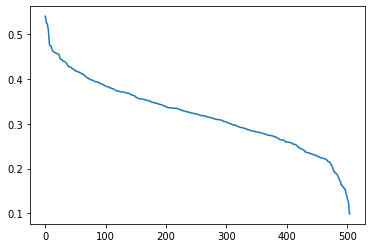

In [273]:
x = np.arange(len(sorted_conv))
y = [c['score'] for c in sorted_conv]
plt.plot(x, y)

In [274]:
# Number of conv with score > 0.45
np.sum([1 for c in sorted_conv if c['score'] > 0.45])

24

# Process data

make predictions as strategies, remove mask, make things shorter

In [275]:
temp = load_pickle('../../../data/negotiation_data/data/strategy_vector_data_w_clustered_strategies.pkl')
category2id = temp['strategies2colid']
del temp

In [276]:
#print (category2id)
id2category = {v:k for k,v in category2id.items()}
print (id2category)

{0: 'agent_id', 1: 'personal_concern', 2: 'friend', 3: 'politeness_greet', 4: 'neg_sentiment', 5: 'assertive_count', 6: 'trade_in', 7: 'number_of_diff_dic_neg', 8: 'factive_count', 9: 'third_person_plural', 10: 'liwc_informal', 11: 'third_person_singular', 12: 'liwc_certainty', 13: 'pos_sentiment', 14: 'first_person_plural_count', 15: 'propose', 16: 'number_of_diff_dic_pos', 17: 'politeness_please', 18: 'politeness_gratitude', 19: 'first_person_singular_count', 20: 'family', 21: 'hedge_count'}


In [277]:
def get_strategies_from_vec(strategies_vec):
    strats = []
    for i in range(len(strategies_vec)):
        idxes = np.where(strategies_vec[i])[0]
        strats.append([id2category[s] for s in idxes if s != 0])
    return strats

In [278]:
def get_cluster_map(input_graphs):
    '''
    Takes list of input graph and augments attention map for each turn
    Also ignore node == 0 for agent
    '''
    cluster_maps = []
    node_list = []
    turn_list = []
    for turn, graph in enumerate(input_graphs):
        num_nodes = graph['x'].shape[0] - np.sum(graph['x'] == 0) # ignore 0
        num_full_nodes = graph['x'].shape[0]
        
        node_list.append([xval for xval in graph['x'].flatten() if xval != 0])
        agent_idxes = [i for i,xval in enumerate(graph['x'].flatten()) if xval == 0]
        turn_arr = np.zeros(num_nodes, dtype=np.int32)
        curr_turn_start = 0
        if turn != 0:
            turn_arr[:len(turn_list[-1])] = turn_list[-1] # copy from prev
            curr_turn_start = len(turn_list[-1])
        turn_arr[curr_turn_start : ] = turn # fill current turn
        turn_list.append(turn_arr)
        
        cluster_map = np.zeros((num_full_nodes, num_full_nodes))
        for i in range(graph['edge_index'].shape[1]): # num edges
            start_node = graph['edge_index'][0][i]
            end_node   = graph['edge_index'][1][i]
            cluster_map[start_node][end_node] = graph['attn_wts'][i][0]
        
        # clean cluster map remove rows and cols with idx in agent_idxes
        cluster_map = np.delete(cluster_map, agent_idxes, axis = 0) # rows
        cluster_map = np.delete(cluster_map, agent_idxes, axis = 1) # cols
        assert cluster_map.shape[0] == num_nodes
        cluster_maps.append(cluster_map)
        
    return cluster_maps, node_list, turn_list

In [279]:
final_conv = []
for c in range(len(sorted_conv)):
    num_utt = sorted_conv[c]['preds'].shape[0]#int(np.sum(sorted_conv[c]['mask']))
    preds = sorted_conv[c]['preds'][:num_utt]
    labels = sorted_conv[c]['labels'][:num_utt]
    pred_strat = get_strategies_from_vec(preds)
    true_strat = get_strategies_from_vec(labels)
    #attn = sorted_conv[c]['attn'][:, :, :num_utt, :num_utt]
    cluster_maps, node_list, turn_list = get_cluster_map(sorted_conv[c]['input_graphs'])
    strat_list = [[id2category[s] for s in nl] for nl in node_list]
    final_conv.append({
        'preds': pred_strat,
        'labels': true_strat,
        #'input_graphs': sorted_conv[c]['input_graphs'],
        'cluster_maps': cluster_maps,
        'node_list': node_list,
        'strat_list': strat_list,
        'turn_list': turn_list,
        'score': sorted_conv[c]['score']
    })

# Visualize Attention Maps of the 6 decoders 2 heads each

In [280]:
final_conv[0]

{'preds': [['personal_concern',
   'friend',
   'politeness_greet',
   'number_of_diff_dic_neg',
   'third_person_plural',
   'liwc_informal',
   'third_person_singular',
   'liwc_certainty',
   'pos_sentiment',
   'number_of_diff_dic_pos',
   'politeness_gratitude',
   'family'],
  ['factive_count',
   'third_person_plural',
   'third_person_singular',
   'pos_sentiment',
   'hedge_count'],
  ['personal_concern',
   'friend',
   'neg_sentiment',
   'assertive_count',
   'trade_in',
   'number_of_diff_dic_neg',
   'factive_count',
   'third_person_plural',
   'liwc_informal',
   'third_person_singular',
   'liwc_certainty',
   'pos_sentiment',
   'first_person_plural_count',
   'number_of_diff_dic_pos',
   'first_person_singular_count',
   'family',
   'hedge_count'],
  ['neg_sentiment',
   'assertive_count',
   'factive_count',
   'third_person_singular',
   'pos_sentiment',
   'propose',
   'first_person_singular_count',
   'hedge_count'],
  ['personal_concern',
   'friend',
   'neg_

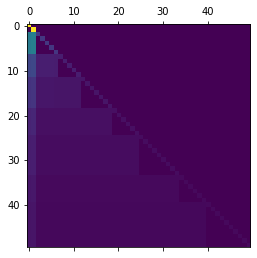

In [281]:
plt.matshow(final_conv[0]['cluster_maps'][-1])#[0][4:5][:])

In [282]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [283]:
def plot_heatmap(turn_list, node_list, scores, rowwise_norm = False, remove_diag = False):

    fig, ax = plt.subplots(figsize=(16,16))
    scores2 = scores.copy()
    #pdb.set_trace()
    if rowwise_norm:
        for i in range(len(scores2)):
            if remove_diag:
                scores2[i,i] = 0
            scores2[i, :] /= np.max(scores2[i, :])
    heatmap = ax.pcolor(scores2, cmap='viridis')
    
    src = [str(turn_list[i]) + '_' + str(node_list[i]) for i in range(len(turn_list))]
    trg = src
    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

In [323]:
print(len(final_conv))

505


6


/usr1/home/rjoshi2/envs/torch110/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


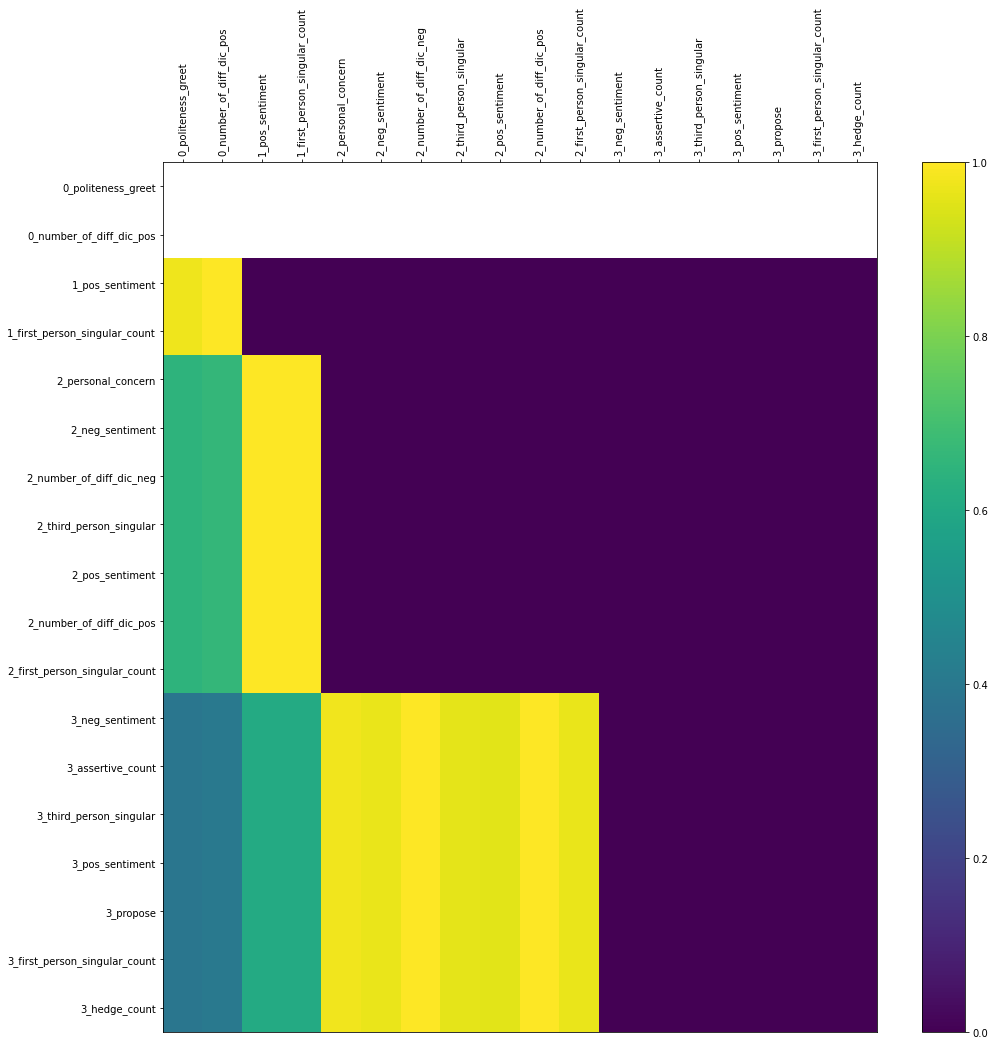

113


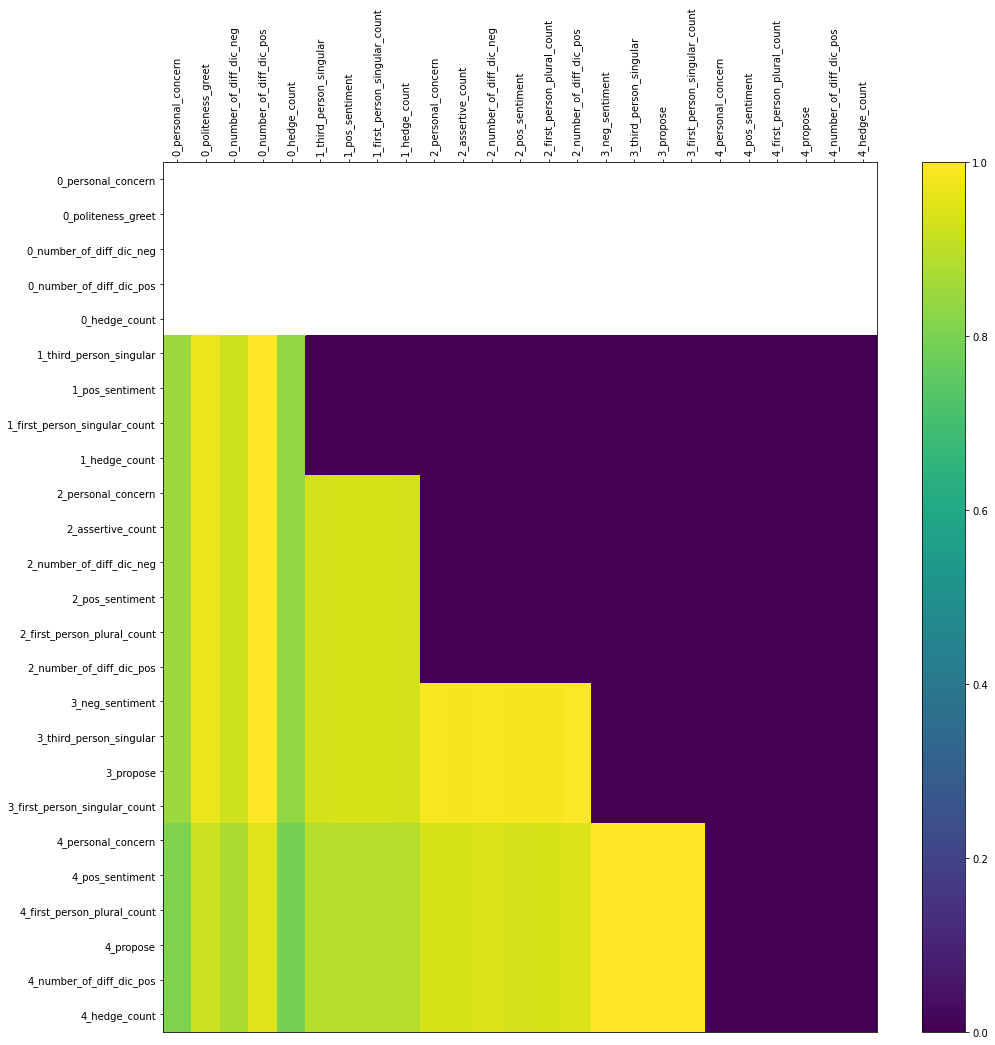

117


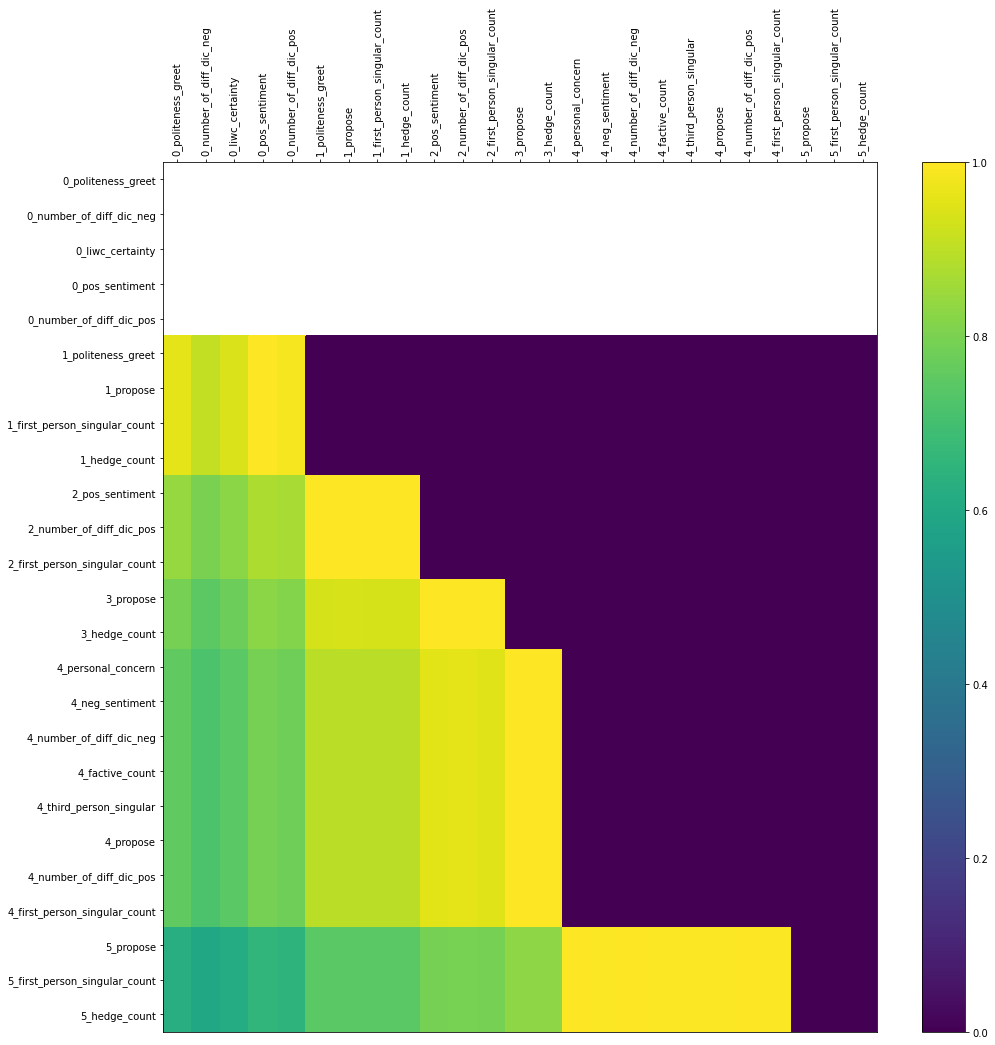

In [328]:
# src = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
# trg = src
# scores = final_conv[0]['attn'][0][0]
for cn in chosen_ids:
    print(cn)
    conv_number = cn
    turn_number = -1
    plot_heatmap(final_conv[conv_number]['turn_list'][turn_number], 
                 final_conv[conv_number]['strat_list'][turn_number], 
                 final_conv[conv_number]['cluster_maps'][turn_number], 
                 rowwise_norm = True,
                 remove_diag = True)

# Plot

In [327]:
#chosen_ids = [6, 7, 18, 21, 22, 32, 33, 70, 94, 113, 117, 119, 228]
chosen_ids = [6,113, 117]

In [307]:
import networkx as nx

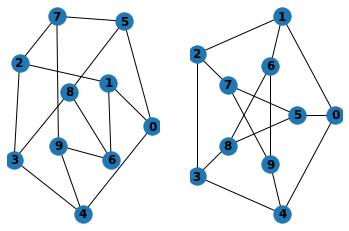

In [308]:
G = nx.petersen_graph()
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels = True, font_weight='bold')

In [311]:
nlist = [range(5, 10), range(5)]

In [313]:
print (list(nlist[0]))
print (list(nlist[1]))

[5, 6, 7, 8, 9]
[0, 1, 2, 3, 4]


In [316]:
G = nx.path_graph(4)
pos = nx.drawing.layout.kamada_kawai_layout(G)

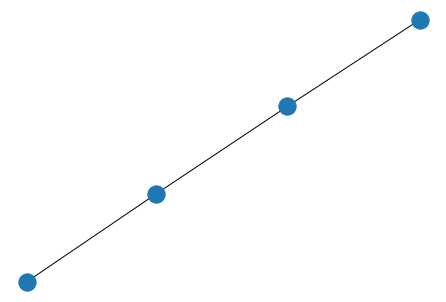

In [319]:
nx.draw_kamada_kawai(G)

In [320]:
pos

{0: array([0.99996577, 0.99366857]),
 1: array([0.32913544, 0.33543827]),
 2: array([-0.33544334, -0.32910684]),
 3: array([-0.99365787, -1.        ])}